# Assignment 2: Training the Fully Recurrent Network

*Author:* Thomas Adler

*Copyright statement:* This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for  personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.


## Exercise 1: Data generation

There are two classes, both occurring with probability 0.5. There is one input unit. Only the first sequence element conveys relevant information about the class. Sequence elements at positions $t > 1$ stem from a Gaussian with mean zero and variance 0.2. The first sequence element is 1.0 (-1.0) for class 1 (2). Target at sequence end is 1.0 (0.0) for class 1 (2)

Write a function `generate_data` that takes an integer `T` as argument which represents the sequence length. Seed the `numpy` random generator with the number `0xDEADBEEF`. Implement the [Python3 generator](https://docs.python.org/3/glossary.html#term-generator) pattern and produce data in the way described above. The input sequences should have the shape `(T, 1)` and the target values should have the shape `(1,)`.

In [1]:
%matplotlib inline
import numpy as np
from scipy.special import expit as sigmoid
import matplotlib.pyplot as plt

class FullyRecurrentNetwork(object):
    def __init__(self, D, I, K):
        self.W = np.random.uniform(-0.01, 0.01, (I, D))
        self.R = np.random.uniform(-0.01, 0.01, (I, I))
        self.V = np.random.uniform(-0.01, 0.01, (K, I))
    
    def forward(self, x, y):
        # helper function for numerically stable loss
        def f(z):
            return np.log1p(np.exp(-np.absolute(z))) + np.maximum(0, z)
        
        # infer dims
        T, D = x.shape
        K, I = self.V.shape

        # init result arrays
        self.x = x
        self.y = y
        self.a = np.zeros((T, I))
        
        # iterate forward in time 
        # trick: access model.a[-1] in first iteration
        for t in range(T):
            self.a[t] = np.tanh(self.W @ x[t] + self.R @ self.a[t-1])
            
        self.z = model.V @ self.a[t]
        return y * f(-self.z) + (1-y) * f(self.z)

T, D, I, K = 10, 3, 5, 1
model = FullyRecurrentNetwork(D, I, K)
model.forward(np.random.uniform(-1, 1, (T, D)), 1)

import random 

def gen(T):
    mu, sigma = 0, 0.2
    for i in range(0,T):
        yield np.random.normal(mu, sigma)


def generate_data(T):
    ########## YOUR SOLUTION HERE ##########
    
    x1 = np.fromiter(gen(T),dtype=float)
    x2 = np.fromiter(gen(T),dtype=float)
    
    x1 = np.reshape(x1,newshape=(T,1))
    x2 = np.reshape(x2,newshape=(T,1))

    x1[0][0] = 1
    y1 = np.array([1.0],dtype=float)

    x2[0][0] = -1.0
    y2 = np.array([0.0],dtype=float)

    choice = np.random.choice([1,-1],1,p=[0.5,0.5])
    if choice[0] == 1:
        return x1,y1 #
         
    else:
        return x2,y2 #



In [2]:
np.random.seed(0xDEADBEEF)

In [3]:
x,y = generate_data(5)
print("x shape: ",x.shape)
print("x[0]:",x[0]," y[0]:",y[0])
print("y shape: ",y.shape)

x shape:  (5, 1)
x[0]: [1.]  y[0]: 1.0
y shape:  (1,)


## Exercise 2: Gradients for the network parameters
Compute gradients of the total loss 
$$
L = \sum_{t=1}^T L(t), \quad \text{where} \quad L(t) = L(z(t), y(t))
$$
w.r.t. the weights of the fully recurrent network. To this end, find the derivative of the loss w.r.t. the logits and hidden pre-activations first, i.e., 
$$
\psi^\top(t) = \frac{\partial L}{\partial z(t)} \quad \text{and} \quad \delta^\top(t) = \frac{\partial L}{\partial s(t)}.
$$
With the help of these intermediate results you should be able to compute the gradients w.r.t. the weights, i.e., $\nabla_W L, \nabla_R L, \nabla_V L$. 

*Hint: Take a look at the computational graph from the previous assignment to see the functional dependencies.*

*Remark: Although we only have one label at the end of the sequence, we consider the more general case of evaluating a loss at every time step in this exercise (many-to-many mapping).*

########## YOUR SOLUTION HERE #########

Let's remember how forward pass looks like:
$$
\vec{s}(t) = \vec{W}^\top \vec{x}(t) + \vec{R}^\top \vec{a}(t-1) \\
\vec{a}(t) = f(\vec{s}(t)) \\
\vec{z}(t) = \vec{V}^\top \vec{a}(t) \\
\hat{\vec{y}}(t) = \phi(\vec{z})
$$
, where $f$ is an $tanh$ - activation function and $\phi$ is $sigmoid$ - output activation function, which depends on the task (not on the architecture)

For the convinience of the future calculations we have to define derivative of the loss w.r.t. pre-activation function $\vec{s}(t)$, which is called delta-error $\vec{\delta}$.
 
Delta can be defined as following:
$$
\vec{\delta}(t)^\top = \frac{\partial \vec{L}}{\partial \vec{s}(t)} = 
\frac{\partial\vec{L}}{\partial\vec{a}(t)}\frac{\partial\vec{a}(t)}{\partial\vec{s}(t)} = \\

\left(\frac{\partial\vec{L}\left(\vec{y}(t),\hat{\vec{y}}(t)\right)}{\partial\vec{a}(t)} + \frac{\partial\vec{L}}{\partial\vec{s}(t+1)} \frac{\partial\vec{s}(t+1)}{\partial\vec{a}(t)}\right)\frac{\partial{\vec{a}(t)}}{\partial{\vec{s}(t)}} = \\[20pt]

\left(\frac{\partial\vec{L}}{\partial\hat{\vec{y}}(t)}\frac{\partial\hat{\vec{y}}(t)}{\partial\vec{z}(t)}\frac{\partial\vec{z}(t)}{\partial\vec{a}(t)} + \frac{\partial\vec{L}}{\partial\vec{s}(t+1)} \frac{\partial\vec{s}(t+1)}{\partial\vec{a}(t)}\right)\frac{\partial{\vec{a}(t)}}{\partial{\vec{s}(t)}}\\ [20pt]
$$
$\\$ Here where it becomes tricky. From the last assignment, we remember that in practice, instead of separate prediction value $\hat{\vec{y}}$,  *logit*  $\vec{z}(t)$ is directly inserted into loss function: $\\ \vec{L}_{\text{BCE stable}}(\vec{z}(t), \vec{y}(t)) =  \log(1+e^{-|z|})+\max(0, z)(1-y)$ . 

So, $\frac{\partial\vec{L}}{\partial\hat{\vec{y}}(t)}\frac{\partial\hat{\vec{y}}(t)}{\partial\vec{z}(t)}$ can be simplified to: $\frac{\partial L_{\text{BCE stable}}(\vec{z}(t), \vec{y}(t))}{\partial \vec{z}(t)}$, which equals to:

$$ 
\frac{\partial L_{\text{BCE stable}}(\vec{z}(t), \vec{y}(t))}{\partial \vec{z}(t)} = \frac{\partial \log(1+e^{-|\vec{z}(t)|})+\max(0, \vec{z}(t))(1-y)}{\partial \vec{\vec{z}(t)}} = - \frac{sgn(\vec{z}(t))}{1+e^{\vec{z}(t)}} + \frac{\max(0, \vec{z}(t))}{\vec{z}(t)}(1-y)
$$
We will not, however, put that whole expression into our calculation of delta, but for the sake of simplicity let it be written  as $\psi(t)^\top$ . Therefore:

$$
... 
\left(\frac{\partial L_{\text{BCE stable}}(\vec{z}(t), \vec{y}(t))}{\partial \vec{z}(t)}\frac{\partial\vec{z}(t)}{\partial\vec{a}(t)} + \frac{\partial\vec{L}}{\partial\vec{s}(t+1)} \frac{\partial\vec{s}(t+1)}{\partial\vec{a}(t)}\right)\frac{\partial{\vec{a}(t)}}{\partial{\vec{s}(t)}} = \\ [20pt]

\left( \psi(t)^\top \vec{V}^\top + \vec{\delta}(t+1)^\top \vec{R}^\top \right)diag\left(f^\prime(\vec{s}(t)) \right) \\[20pt]
$$
Whereas $f^\prime(\vec{s}(t)) = \frac{\partial\, tanh(\vec{s}(t)) }{\partial\, \vec{s}(t)} = \frac{1}{cosh^2(\vec{s}(t))}$

Using delta we can easily calculate gradients w.r.t. weights:
$$
\nabla_{\vec{R}} \vec{L} = \sum_{t=1}^T \frac{\partial \vec{L}}{\partial\vec{s}(t)}\frac{\partial\vec{s}(t)}{\partial\vec{R}} = \sum_{t=1}^T \vec{\delta}(t)^\top \frac{\partial \left(\vec{W}^\top \vec{x}(t) + \vec{R}^\top \vec{a}(t-1) \right)}{\partial \vec{R}} =
\sum_{t=1}^T \vec{\delta}(t)^\top \vec{a}(t-1) \\ [20pt]

\nabla_{\vec{W}} \vec{L} =  \sum_{t=1}^T \frac{\partial \vec{L}}{\partial\vec{s}(t)}\frac{\partial\vec{s}(t)}{\partial\vec{W}} = \sum_{t=1}^T \vec{\delta}(t)^\top \frac{\partial \left(\vec{W}^\top \vec{x}(t) + \vec{R}^\top \vec{a}(t-1) \right)}{\partial \vec{W}} =
\sum_{t=1}^T \vec{\delta}(t)^\top \vec{x}(t) \\ [20pt]
$$

To find gradient for $\vec{V}$ we shouldn't fo deep down untill $\vec{s}(t)$, because $\vec{V}$ can calculated using $\psi(t)^\top$ .  
$$
\vec{\psi}^\top(t) = \frac{\partial L_{\text{BCE stable}}(\vec{z}(t), \vec{y}(t))}{\partial \vec{z}(t)} = \frac{\partial L_{\text{BCE stable}}(\vec{z}(t), \vec{y}(t))}{\partial\vec{V}^\top\; \vec{a}(t)}
$$


Multiplying this definition with $\vec{a}(t)$ will cancel out $\vec{a}(t)$ in denominator:
$$
\nabla_{\vec{V}} \vec{L} = \sum_{t=1}^T \frac{\partial L_{\text{BCE stable}}(\vec{z}(t), \vec{y}(t))}{\partial\vec{V}^\top\; \cancel{\vec{a}(t)}} \cancel{\;\vec{a}(t)} = \sum_{t=1}^T \vec{\psi}(t)\;\vec{a}(t)^\top
$$

## Exercise 3: The backward pass
Write a function `backward` that takes a model `self` as argument. The function should compute the gradients of the loss with respect to all model parameters and store them to `self.dW`, `self.dR`, `self.dV`, respectively. 

In [5]:
def backward(self): 
    delta = np.zeros((T,I))
    self.gradR = 0
    self.gradW = 0
    self.gradV = 0
    dL_da = np.zeros((T,I))

    
    # calculate psi[t]
    # Loss formula was directly taken from forward pass   #
    psi = - (np.sign(self.z))/(np.exp(np.abs(self.z))+1) \
          + (np.max([0,self.z])/self.z)*(1-self.y) 
    # derivative of the unstable bce loss    
    # psi = (np.exp(self.z)*(self.y-1)+self.y) / (np.exp(self.z)+1)              
                                    

    # just before start looping, calculate dL_da for the last position once using psi,
    # since we won't have psi[t] anymore
    dL_da[-1] = psi.reshape(1,1) @ self.V

    # calculate delta[t]
    # delta = dL/da * da/ds
    for t in reversed(range(0, T)):

        # complete dL_da in case we've got already delta[t+1], i.e. we aren't at the end     
        if t < (T-1): 
            dL_da[t] += delta[t+1] @ self.R 

        # calculate s_t for diag(f's(t)), i.e. dor da/ds
        s_t = self.W @ self.x[t].reshape(D,1)
        # complete s_t for two cases: t>0 and t==0
        if t > 0:
            s_t += self.R @ self.a[t-1].reshape(I,1)
        else:
            s_t += self.R @ np.zeros_like(self.a[t]).reshape(I,1)
        # insert s_t into formula, so we have da_ds
        da_ds = np.diag(1/(np.cosh(s_t))**2)
        
        # finally, calculate delta
        delta[t] = dL_da[t].reshape(I,1) @ da_ds
    
    # calculate gradients 
    for t in range(0, T):
        #calculate self.gradR
        if t!=0:       
            self.gradR += delta[t].reshape(I,1) @ self.a[t-1].reshape(1,I)
        # calculate gradW
        self.gradW += delta[t].reshape(I,1) @ self.x[t].reshape(1,D)
        # calculate self.gradV
        if len(psi)!=1:
            self.gradV += psi[t].reshape(K,K) @ self.a[t].reshape(K,I)
    if len(psi) == 1:
        self.gradV += psi[-1].reshape(K,K) @ self.a[-1].reshape(K,I)
    
FullyRecurrentNetwork.backward = backward
model.backward()

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


## Exercise 4: Gradient checking
Write a function `grad_check` that takes a model `self`, a float `eps` and another float `thresh` as arguments and computes the numerical gradients of the model parameters according to the approximation
$$
f'(x) \approx \frac{f(x + \varepsilon) - f(x - \varepsilon)}{2 \varepsilon}.
$$
If any of the analytical gradients are farther than `thresh` away from the numerical gradients the function should throw an error. 

In [6]:
def grad_check(self, eps, thresh):
    ########## YOUR SOLUTION HERE ##########
    self.eps = eps
    self.thresh = thresh

    # add eps to all weights
    self.W = self.W + self.eps
    self.V = self.V + self.eps
    self.R = self.R + self.eps
    #call forward() to make forward pass
    lossPlusEps = self.forward(self.x,self.y)

    # minus 2eps from to prev added weights, to make it x-e
    self.W = self.W - 2*self.eps
    self.V = self.V - 2*self.eps
    self.R = self.R - 2*self.eps
    # call forward() to make another forward pass
    lossMinusEps = self.forward(self.x,self.y)
    
    # calculate numerical gradient
    gradApprox = ((lossPlusEps - lossMinusEps)/(2*self.eps))[0]
    print("grad approx-on: ", gradApprox,"\n")
    for row in self.gradV:
        print("checking gradients for V")
        for dV in row:
            diff = np.abs(gradApprox - dV) 
            diff = np.linalg.norm(gradApprox-dV)/(np.linalg.norm(dV)+np.linalg.norm(gradApprox))
            if diff > self.thresh:
                print("Error! diff > theshold")
                print(f"dV: {dV}, diff: {diff}")
    for row in self.gradW:
        print("checking gradients for W")
        for dW in row:
            diff = np.linalg.norm(-dW+gradApprox)/(np.linalg.norm(dW)+np.linalg.norm(gradApprox))
            if diff > self.thresh:
                print("Error! diff > theshold")
                print(f"dV: {dV}, diff: {diff}")
    for row in self.gradR:
        print("checking gradients for R")
        for dR in row:
            diff = np.linalg.norm(-dR+gradApprox)/(np.linalg.norm(dR)+np.linalg.norm(gradApprox))
            if diff > self.thresh:
                print("Error! diff > theshold")
                print(f"dR: {dR}, diff: {diff}")
   
    # restore model weights to the default ones
    self.W = self.W + self.eps
    self.V = self.V + self.eps
    self.R = self.R + self.eps

FullyRecurrentNetwork.grad_check = grad_check
model.grad_check(1e-7, 1e-7)

grad approx-on:  0.0028716173883225338 

checking gradients for V
Error! diff > theshold
dV: 0.003473400530329167, diff: 0.09484341095990326
Error! diff > theshold
dV: -0.0007184505466095768, diff: 1.0
Error! diff > theshold
dV: -0.0036268944136883872, diff: 1.0
Error! diff > theshold
dV: 0.0019287892507175147, diff: 0.19640588985468932
Error! diff > theshold
dV: -0.005077216352129037, diff: 1.0
checking gradients for W
Error! diff > theshold
dV: -0.005077216352129037, diff: 0.011939837031187353
Error! diff > theshold
dV: -0.005077216352129037, diff: 1.0
Error! diff > theshold
dV: -0.005077216352129037, diff: 0.08344322408075976
checking gradients for W
Error! diff > theshold
dV: -0.005077216352129037, diff: 0.14497296917369948
Error! diff > theshold
dV: -0.005077216352129037, diff: 1.0
Error! diff > theshold
dV: -0.005077216352129037, diff: 0.1994379972540116
checking gradients for W
Error! diff > theshold
dV: -0.005077216352129037, diff: 0.04583184413412049
Error! diff > theshold
dV:

## Exercise 5: Parameter update

Write a function `update` that takes a model `self` and a float argument `eta`, which represents the learning rate. The method should implement the gradient descent update rule $\theta \gets \theta - \eta \nabla_{\theta}L$ for all model parameters $\theta$.

In [7]:
def update(self, eta):
    self.W -= eta * self.gradW
    self.V -= eta * self.gradV
    self.R -= eta * self.gradR   

FullyRecurrentNetwork.update = update
model.update(0.001)

## Exercise 6: Network training

Train the fully recurrent network with 32 hidden units. Start with input sequences of length one and tune the learning rate and the number of update steps. Then increase the sequence length by one and tune the hyperparameters again. What is the maximal sequence length for which the fully recurrent network can achieve a performance that is better than random? Visualize your results. 

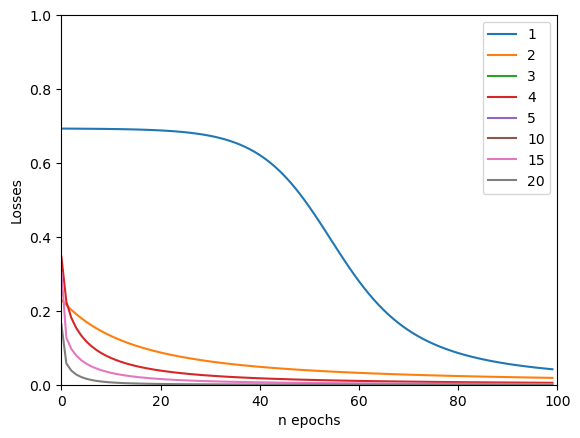

In [8]:
########## YOUR SOLUTION HERE ##########
import pandas as pd
np.random.seed(0xDEADBEEF)
D,I,K = 3,32,1

model = FullyRecurrentNetwork(D,I,K)

max_epochs = 100
lr = 0.1

Ts = [1,2,3,4,5,10,15,20]



#fig = plt.figure(figsize=(8,3))
for T in Ts:
    T_loss = []
    X = np.random.uniform(-1, 1,(T,D))
    Y = np.random.choice([1,0],1,p=[0.5,0.5])[0]
    for epochs in range(max_epochs):
        T_loss.append(model.forward(X,1)[0])
        model.backward()
        model.update(lr)
    plt.plot(T_loss, label=T)


plt.xlabel("n epochs")
plt.ylabel("Losses")

plt.legend()
plt.axis([0, max_epochs, 0, 1])
# function to show the plot
plt.show()

## Exercise 7: The Vanishing Gradient Problem

Analyze why the network is incapable of learning long-term dependencies. Show that $\|\frac{\partial a(T)}{\partial a(1)}\|_2 \leq \|R\|_2^{T-1}$ , where $\|\cdot\|_2$ is the spectral norm, and discuss how that affects the propagation of error signals through the time dimension of the network. 

*Hint: Use the fact that the spectral norm is submultiplicative for square matrices, i.e. $\|AB\|_2 \leq \|A\|_2\|B\|_2$ if $A$ and $B$ are both square.*

########## YOUR SOLUTION HERE ##########